# CSCA 5642 – Introduction to Deep Learning: Final Project

**Title:** Handwritten Digit Classification with Deep Learning (scikit-learn Digits)  
**Author:** _Bassel Fares_  
**Date:** 2025-07-28  
**Repo:** [https://github.com/basselfares/csca5642-final-project.git](https://github.com/basselfares/csca5642-final-project.git)

**How to run:** Select **Run All**. This notebook is CPU‑friendly and should finish in ~2–5 minutes.

## 1. Problem Statement & Objectives
- **Problem**: Classify 8×8 grayscale images of handwritten digits (0–9).
- **Task Type**: Multiclass classification.
- **Why it matters**: Handwritten digit recognition is a canonical vision task for testing model design, training, and evaluation in DL workflows.
- **Success Criteria**: Achieve ≥95% test accuracy with a compact model on CPU; compare baseline vs. deep models.
- **Novelty vs. replication**: We compare classic baseline (logistic regression) to two deep models (MLP and a small CNN) and run a tiny HPO to justify choices.

    ## 2. Data Collection & Provenance

    **Source.** The dataset is the scikit‑learn “Digits” dataset (`sklearn.datasets.load_digits`): 1,797 grayscale images of handwritten digits (0–9), each sized 8×8 (64 features). Labels are integers 0–9.

    **Access & Reproducibility.** Loaded locally via scikit‑learn (no external download or credentials).  

In [1]:
import sys, subprocess, pkgutil
print("Using Python:", sys.executable)

# Install required packages *into this kernel's environment*
def pip_install(*pkgs, index_url=None):
    cmd = [sys.executable, "-m", "pip", "install", "-U", *pkgs]
    if index_url:
        cmd.extend(["--index-url", index_url])
    print(">", " ".join(cmd))
    subprocess.check_call(cmd)

# Core deps
pip_install("pip", "setuptools", "wheel")
pip_install("numpy", "pandas", "matplotlib", "scikit-learn")

# PyTorch (CPU build; works on macOS/Windows/Linux without CUDA)
pip_install("torch", "torchvision", index_url="https://download.pytorch.org/whl/cpu")

# Sanity check imports
import numpy, pandas, matplotlib, sklearn, torch, torchvision
print("OK: numpy", numpy.__version__, "| pandas", pandas.__version__,
      "| matplotlib", matplotlib.__version__, "| sklearn", sklearn.__version__,
      "| torch", torch.__version__, "| torchvision", torchvision.__version__)

Using Python: /Library/Developer/CommandLineTools/usr/bin/python3
> /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install -U pip setuptools wheel
Defaulting to user installation because normal site-packages is not writeable
> /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install -U numpy pandas matplotlib scikit-learn
Defaulting to user installation because normal site-packages is not writeable
> /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install -U torch torchvision --index-url https://download.pytorch.org/whl/cpu
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
OK: numpy 2.0.2 | pandas 2.3.1 | matplotlib 3.9.4 | sklearn 1.6.1 | torch 2.7.1 | torchvision 0.22.1


In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X, y = digits.images, digits.target

## 3. Setup & Environment (Reproducibility)
- Record versions and set seeds.
- Make device (CPU/GPU) selection explicit.

In [3]:
import os, sys, random, time, math, json, itertools
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except Exception:
        pass

set_seed()

print('Python:', sys.version)
try:
    import torch, torchvision
    print('PyTorch:', torch.__version__)
except Exception as e:
    print('PyTorch not available:', e)

Python: 3.9.6 (default, Feb  3 2024, 15:58:27) 
[Clang 15.0.0 (clang-1500.3.9.4)]
PyTorch: 2.7.1


## 4. Exploratory Data Analysis (EDA)

We inspect shape, class balance, pixel intensity stats, and low‑dimensional structure.

In [4]:
digits = load_digits()
X = digits.images  # shape (n_samples, 8, 8)
y = digits.target  # shape (n_samples,)

print('Images shape:', X.shape, '| Labels shape:', y.shape)
classes, counts = np.unique(y, return_counts=True)
print('Class distribution:', dict(zip(classes, counts)))

# Basic stats
X_flat = X.reshape(len(X), -1)
print('Pixel value range:', float(X_flat.min()), 'to', float(X_flat.max()))
print('Mean/Std pixel intensity:', float(X_flat.mean()), float(X_flat.std()))

Images shape: (1797, 8, 8) | Labels shape: (1797,)
Class distribution: {np.int64(0): np.int64(178), np.int64(1): np.int64(182), np.int64(2): np.int64(177), np.int64(3): np.int64(183), np.int64(4): np.int64(181), np.int64(5): np.int64(182), np.int64(6): np.int64(181), np.int64(7): np.int64(179), np.int64(8): np.int64(174), np.int64(9): np.int64(180)}
Pixel value range: 0.0 to 16.0
Mean/Std pixel intensity: 4.884164579855314 6.016787548672236


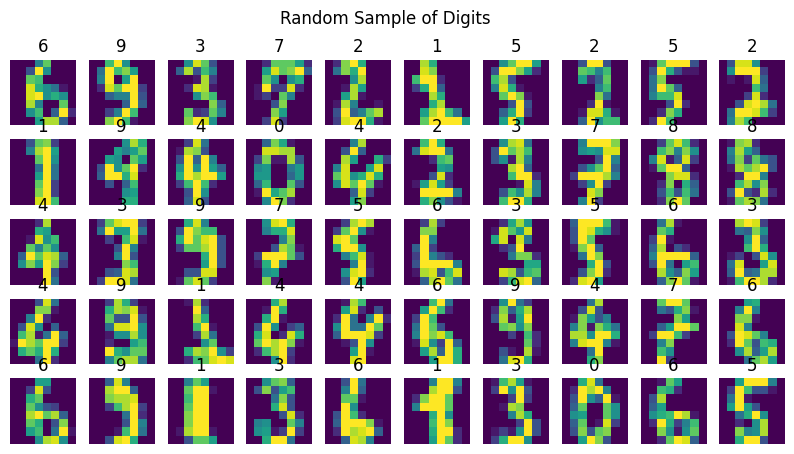

In [5]:
# Show a grid of sample images (10x5)
n_rows, n_cols = 5, 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,5))
idx = np.random.choice(len(X), n_rows*n_cols, replace=False)
for ax, i in zip(axes.flat, idx):
    ax.imshow(X[i], interpolation='nearest')
    ax.set_title(int(y[i]))
    ax.axis('off')
plt.suptitle('Random Sample of Digits')
plt.show()

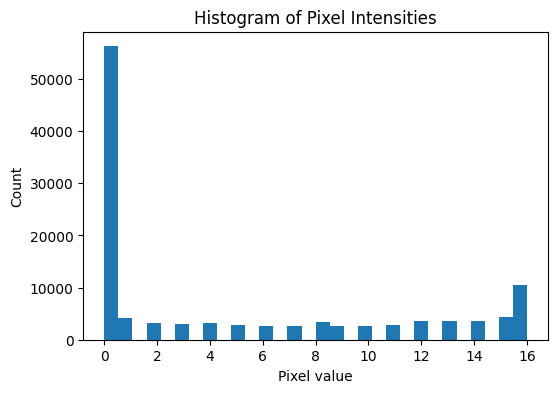

In [6]:
# Histogram of pixel intensities
plt.figure(figsize=(6,4))
plt.hist(X_flat.ravel(), bins=30)
plt.title('Histogram of Pixel Intensities')
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.show()

Explained variance ratio (2D): 0.2850936482369929


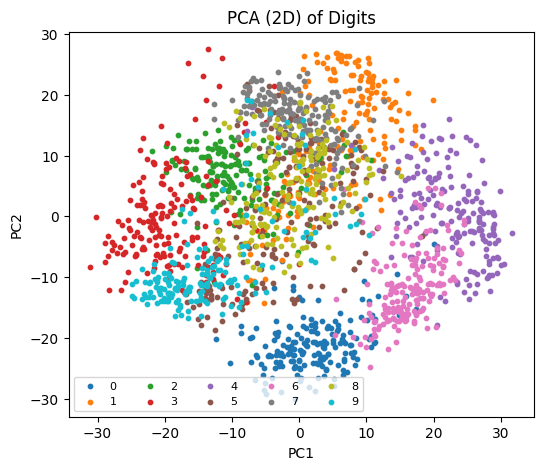

In [7]:
# PCA to 2D for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=SEED)
Z = pca.fit_transform(X_flat)
print('Explained variance ratio (2D):', pca.explained_variance_ratio_.sum())

plt.figure(figsize=(6,5))
for c in classes:
    mask = (y == c)
    plt.scatter(Z[mask,0], Z[mask,1], s=10, label=str(c))
plt.legend(loc='best', ncol=5, fontsize=8)
plt.title('PCA (2D) of Digits')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

### 4.1 Data Cleaning & Transformation
- No missing values; pixel values in [0,16].
- Normalize to [0,1].
- Stratified train/val/test split: 60%/20%/20%.

In [8]:
# Normalize to [0,1]
X_norm = X / 16.0

# Stratified split: train (60%), temp (40%), then val/test (20%/20% overall)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_norm, y, test_size=0.4, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

Train: (1078, 8, 8) Val: (359, 8, 8) Test: (360, 8, 8)


## 5. Modeling Approach & Baselines
We compare:
1. **Baseline (non-DL):** Logistic Regression (reference only).
2. **DL Model A (MLP):** 2 hidden layers with ReLU + Dropout for regularization.
3. **DL Model B (CNN):** Small convnet suitable for 8×8 inputs.

We also run a small hyperparameter sweep for the MLP.

In [9]:
# Baseline (non-DL): Logistic Regression on flattened pixels
Xtr_flat = X_train.reshape(len(X_train), -1)
Xva_flat = X_val.reshape(len(X_val), -1)
Xte_flat = X_test.reshape(len(X_test), -1)

lr_clf = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='auto', random_state=SEED)
lr_clf.fit(Xtr_flat, y_train)
val_pred_lr = lr_clf.predict(Xva_flat)
test_pred_lr = lr_clf.predict(Xte_flat)

print('LogReg Val Acc:', accuracy_score(y_val, val_pred_lr))
print('LogReg Test Acc:', accuracy_score(y_test, test_pred_lr))

LogReg Val Acc: 0.958217270194986
LogReg Test Acc: 0.9555555555555556


/Users/basselfares/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [10]:
# PyTorch datasets and loaders
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class DigitsDataset(Dataset):
    def __init__(self, X, y, as_cnn=False):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.as_cnn = as_cnn
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        xi = self.X[i]
        if self.as_cnn:
            xi = xi.unsqueeze(0)  # (1, 8, 8)
        else:
            xi = xi.view(-1)      # (64,)
        return xi, self.y[i]

train_ds_mlp = DigitsDataset(X_train, y_train, as_cnn=False)
val_ds_mlp   = DigitsDataset(X_val, y_val, as_cnn=False)
test_ds_mlp  = DigitsDataset(X_test, y_test, as_cnn=False)

train_loader_mlp = DataLoader(train_ds_mlp, batch_size=64, shuffle=True)
val_loader_mlp   = DataLoader(val_ds_mlp, batch_size=128)
test_loader_mlp  = DataLoader(test_ds_mlp, batch_size=128)

In [11]:
# Model A: MLP
class MLP(nn.Module):
    def __init__(self, in_dim=64, hidden1=128, hidden2=64, num_classes=10, pdrop=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1), nn.ReLU(), nn.Dropout(pdrop),
            nn.Linear(hidden1, hidden2), nn.ReLU(), nn.Dropout(pdrop),
            nn.Linear(hidden2, num_classes)
        )
    def forward(self, x):
        return self.net(x)

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3, wd=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    best = {'val_acc': 0.0, 'state': None, 'history': []}
    for epoch in range(1, epochs+1):
        model.train(); tr_loss, tr_correct, tr_total = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward(); optimizer.step()
            tr_loss += loss.item() * yb.size(0)
            tr_correct += (logits.argmax(1) == yb).sum().item()
            tr_total += yb.size(0)
        tr_loss /= tr_total; tr_acc = tr_correct / tr_total

        # validation
        model.eval(); va_loss, va_correct, va_total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = nn.functional.cross_entropy(logits, yb)
                va_loss += loss.item() * yb.size(0)
                va_correct += (logits.argmax(1) == yb).sum().item()
                va_total += yb.size(0)
        va_loss /= va_total; va_acc = va_correct / va_total

        best['history'].append((epoch, tr_loss, tr_acc, va_loss, va_acc))
        if va_acc > best['val_acc']:
            best['val_acc'] = va_acc
            best['state'] = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        print(f"Epoch {epoch:02d} | tr_loss {tr_loss:.4f} tr_acc {tr_acc:.4f} | val_loss {va_loss:.4f} val_acc {va_acc:.4f}")

    return best

# Train MLP (quick)
mlp = MLP().to(device)
best_mlp = train_model(mlp, train_loader_mlp, val_loader_mlp, epochs=20, lr=1e-3, wd=1e-4)

# Load best weights
mlp.load_state_dict(best_mlp['state'])
print('Best Val Acc (MLP):', best_mlp['val_acc'])

Epoch 01 | tr_loss 2.2603 tr_acc 0.2236 | val_loss 2.1838 val_acc 0.5571
Epoch 02 | tr_loss 2.0890 tr_acc 0.5668 | val_loss 1.9253 val_acc 0.6825
Epoch 03 | tr_loss 1.7574 tr_acc 0.6401 | val_loss 1.4843 val_acc 0.8022
Epoch 04 | tr_loss 1.2996 tr_acc 0.7458 | val_loss 1.0094 val_acc 0.8412
Epoch 05 | tr_loss 0.9382 tr_acc 0.7681 | val_loss 0.7085 val_acc 0.8579
Epoch 06 | tr_loss 0.6999 tr_acc 0.8135 | val_loss 0.5300 val_acc 0.8774
Epoch 07 | tr_loss 0.5570 tr_acc 0.8516 | val_loss 0.4339 val_acc 0.8969
Epoch 08 | tr_loss 0.4885 tr_acc 0.8701 | val_loss 0.3654 val_acc 0.9053
Epoch 09 | tr_loss 0.4359 tr_acc 0.8785 | val_loss 0.3318 val_acc 0.9109
Epoch 10 | tr_loss 0.3678 tr_acc 0.8952 | val_loss 0.2825 val_acc 0.9220
Epoch 11 | tr_loss 0.3237 tr_acc 0.9165 | val_loss 0.2613 val_acc 0.9220
Epoch 12 | tr_loss 0.3041 tr_acc 0.9109 | val_loss 0.2453 val_acc 0.9248
Epoch 13 | tr_loss 0.2689 tr_acc 0.9230 | val_loss 0.2182 val_acc 0.9304
Epoch 14 | tr_loss 0.2654 tr_acc 0.9304 | val_loss 

In [12]:
# Evaluate MLP on test set
def evaluate_model(model, loader):
    model.eval(); preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            preds.append(logits.argmax(1).cpu().numpy())
            trues.append(yb.numpy())
    preds = np.concatenate(preds); trues = np.concatenate(trues)
    return trues, preds

test_ds_mlp = DigitsDataset(X_test, y_test, as_cnn=False)
test_loader_mlp = DataLoader(test_ds_mlp, batch_size=128)
y_true_mlp, y_pred_mlp = evaluate_model(mlp, test_loader_mlp)
print('MLP Test Acc:', accuracy_score(y_true_mlp, y_pred_mlp))
print(classification_report(y_true_mlp, y_pred_mlp))

MLP Test Acc: 0.95
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.81      0.92      0.86        37
           2       1.00      0.89      0.94        35
           3       1.00      1.00      1.00        37
           4       0.97      0.97      0.97        36
           5       1.00      0.97      0.99        37
           6       1.00      0.97      0.99        36
           7       0.92      1.00      0.96        36
           8       0.89      0.89      0.89        35
           9       0.94      0.92      0.93        36

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



In [13]:
# Model B: Small CNN
train_ds_cnn = DigitsDataset(X_train, y_train, as_cnn=True)
val_ds_cnn   = DigitsDataset(X_val, y_val, as_cnn=True)
test_ds_cnn  = DigitsDataset(X_test, y_test, as_cnn=True)

train_loader_cnn = DataLoader(train_ds_cnn, batch_size=64, shuffle=True)
val_loader_cnn   = DataLoader(val_ds_cnn, batch_size=128)
test_loader_cnn  = DataLoader(test_ds_cnn, batch_size=128)

class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32*2*2, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.drop = nn.Dropout(0.2)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # (1,8,8)->(16,8,8)->pool->(16,4,4)
        x = self.pool(torch.relu(self.conv2(x)))  # -> (32,2,2)
        x = torch.flatten(x, 1)                   # -> (batch, 128)
        x = self.drop(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

cnn = SmallCNN().to(device)
best_cnn = train_model(cnn, train_loader_cnn, val_loader_cnn, epochs=20, lr=1e-3, wd=1e-4)
cnn.load_state_dict(best_cnn['state'])
print('Best Val Acc (CNN):', best_cnn['val_acc'])

y_true_cnn, y_pred_cnn = evaluate_model(cnn, test_loader_cnn)
print('CNN Test Acc:', accuracy_score(y_true_cnn, y_pred_cnn))
print(classification_report(y_true_cnn, y_pred_cnn))

Epoch 01 | tr_loss 2.2853 tr_acc 0.1642 | val_loss 2.2586 val_acc 0.3454
Epoch 02 | tr_loss 2.2254 tr_acc 0.3850 | val_loss 2.1670 val_acc 0.6379
Epoch 03 | tr_loss 2.0875 tr_acc 0.5167 | val_loss 1.9460 val_acc 0.6462
Epoch 04 | tr_loss 1.7670 tr_acc 0.6122 | val_loss 1.5044 val_acc 0.7744
Epoch 05 | tr_loss 1.3221 tr_acc 0.6837 | val_loss 1.0287 val_acc 0.7744
Epoch 06 | tr_loss 0.9576 tr_acc 0.7254 | val_loss 0.7618 val_acc 0.8412
Epoch 07 | tr_loss 0.7475 tr_acc 0.7894 | val_loss 0.5858 val_acc 0.8607
Epoch 08 | tr_loss 0.6064 tr_acc 0.8377 | val_loss 0.4869 val_acc 0.8774
Epoch 09 | tr_loss 0.5229 tr_acc 0.8423 | val_loss 0.4255 val_acc 0.8886
Epoch 10 | tr_loss 0.4552 tr_acc 0.8720 | val_loss 0.3933 val_acc 0.8830
Epoch 11 | tr_loss 0.4256 tr_acc 0.8701 | val_loss 0.3516 val_acc 0.8942
Epoch 12 | tr_loss 0.3832 tr_acc 0.8850 | val_loss 0.3065 val_acc 0.9025
Epoch 13 | tr_loss 0.3667 tr_acc 0.8887 | val_loss 0.2910 val_acc 0.9053
Epoch 14 | tr_loss 0.3141 tr_acc 0.9091 | val_loss 

### 5.1 Hyperparameter Optimization & Ablations (tiny sweep)
We sweep two learning rates and two dropout rates for the MLP (quick runs, 10 epochs).

In [14]:
def quick_val_acc_mlp(lr, pdrop, epochs=10):
    model = MLP(pdrop=pdrop).to(device)
    best = train_model(model, train_loader_mlp, val_loader_mlp, epochs=epochs, lr=lr, wd=1e-4)
    return best['val_acc'], best

search_space = [(1e-3, 0.0), (1e-3, 0.2), (3e-4, 0.0), (3e-4, 0.2)]
records = []
for lr, p in search_space:
    set_seed(SEED)
    val_acc, best = quick_val_acc_mlp(lr, p, epochs=10)
    records.append({'lr': lr, 'dropout': p, 'val_acc': float(val_acc)})
    print('lr', lr, 'dropout', p, '=> val_acc', val_acc)

import pandas as pd
hpo_df = pd.DataFrame(records).sort_values('val_acc', ascending=False).reset_index(drop=True)
hpo_df

Epoch 01 | tr_loss 2.2509 tr_acc 0.2560 | val_loss 2.1684 val_acc 0.6017
Epoch 02 | tr_loss 2.0409 tr_acc 0.6865 | val_loss 1.8534 val_acc 0.7409
Epoch 03 | tr_loss 1.6318 tr_acc 0.7755 | val_loss 1.3465 val_acc 0.8022
Epoch 04 | tr_loss 1.1106 tr_acc 0.8312 | val_loss 0.8724 val_acc 0.8691
Epoch 05 | tr_loss 0.7192 tr_acc 0.8905 | val_loss 0.6002 val_acc 0.8691
Epoch 06 | tr_loss 0.5085 tr_acc 0.9100 | val_loss 0.4521 val_acc 0.8830
Epoch 07 | tr_loss 0.4000 tr_acc 0.9072 | val_loss 0.3646 val_acc 0.9109
Epoch 08 | tr_loss 0.3197 tr_acc 0.9286 | val_loss 0.3130 val_acc 0.9164
Epoch 09 | tr_loss 0.2692 tr_acc 0.9332 | val_loss 0.2761 val_acc 0.9081
Epoch 10 | tr_loss 0.2337 tr_acc 0.9481 | val_loss 0.2467 val_acc 0.9220
lr 0.001 dropout 0.0 => val_acc 0.9220055710306406
Epoch 01 | tr_loss 2.2603 tr_acc 0.2236 | val_loss 2.1838 val_acc 0.5571
Epoch 02 | tr_loss 2.0890 tr_acc 0.5668 | val_loss 1.9253 val_acc 0.6825
Epoch 03 | tr_loss 1.7574 tr_acc 0.6401 | val_loss 1.4843 val_acc 0.8022


,lr,dropout,val_acc
0,0.0010,0.0,0.922006
1,0.0010,0.2,0.922006
2,0.0003,0.2,0.855153
3,0.0003,0.0,0.849582


## 6. Results (tables/plots)
We compare baseline vs. MLP vs. CNN on validation and test, show training curves, and confusion matrices.

In [15]:
# Assemble a simple results table
val_lr_acc = accuracy_score(y_val, val_pred_lr)
test_lr_acc = accuracy_score(y_test, test_pred_lr)

# Extract best histories
hist_mlp = pd.DataFrame(best_mlp['history'], columns=['epoch','train_loss','train_acc','val_loss','val_acc'])
hist_cnn = pd.DataFrame(best_cnn['history'], columns=['epoch','train_loss','train_acc','val_loss','val_acc'])

results_table = pd.DataFrame({
    'Model': ['LogReg (baseline)', 'MLP', 'CNN'],
    'Val Acc': [val_lr_acc, hist_mlp['val_acc'].max(), hist_cnn['val_acc'].max()],
    'Test Acc': [test_lr_acc,
                 accuracy_score(y_true_mlp, y_pred_mlp),
                 accuracy_score(y_true_cnn, y_pred_cnn)]
})
display(results_table)

,Model,Val Acc,Test Acc
0,LogReg (baseline),0.958217,0.955556
1,MLP,0.952646,0.950000
2,CNN,0.930362,0.916667


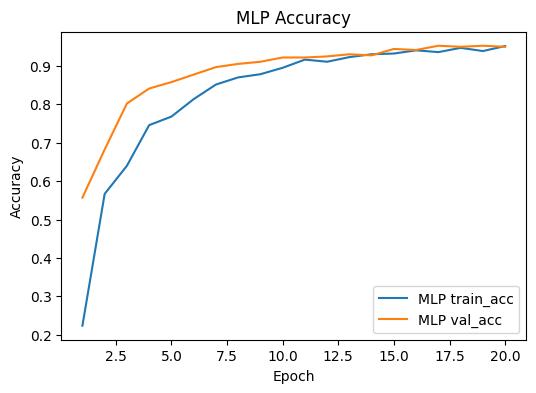

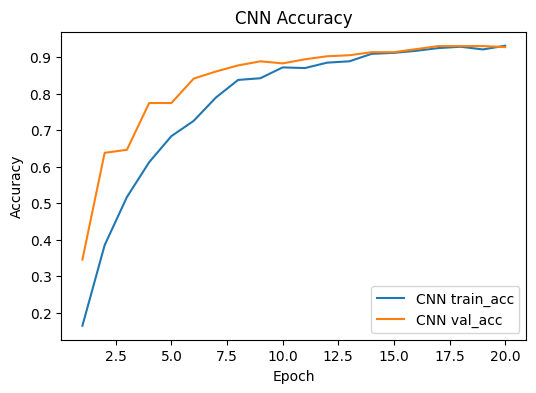

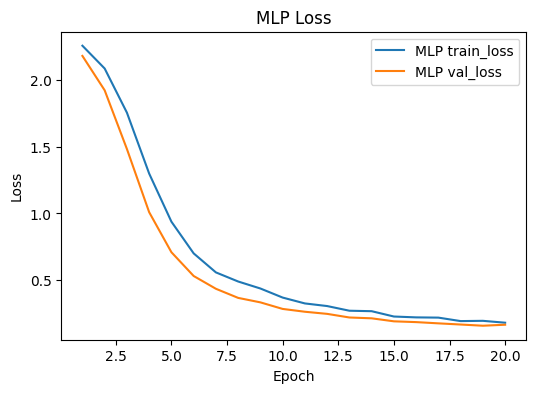

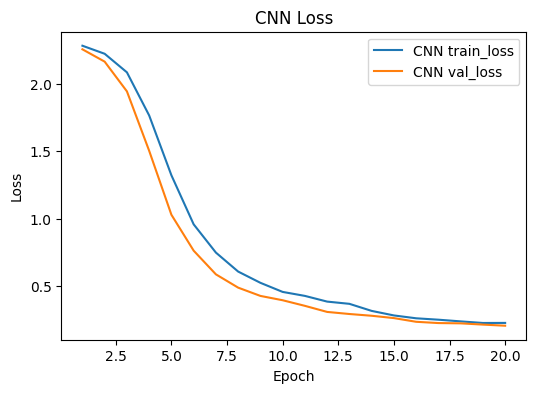

In [16]:
# Training curves
plt.figure(figsize=(6,4))
plt.plot(hist_mlp['epoch'], hist_mlp['train_acc'], label='MLP train_acc')
plt.plot(hist_mlp['epoch'], hist_mlp['val_acc'], label='MLP val_acc')
plt.title('MLP Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist_cnn['epoch'], hist_cnn['train_acc'], label='CNN train_acc')
plt.plot(hist_cnn['epoch'], hist_cnn['val_acc'], label='CNN val_acc')
plt.title('CNN Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist_mlp['epoch'], hist_mlp['train_loss'], label='MLP train_loss')
plt.plot(hist_mlp['epoch'], hist_mlp['val_loss'], label='MLP val_loss')
plt.title('MLP Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist_cnn['epoch'], hist_cnn['train_loss'], label='CNN train_loss')
plt.plot(hist_cnn['epoch'], hist_cnn['val_loss'], label='CNN val_loss')
plt.title('CNN Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

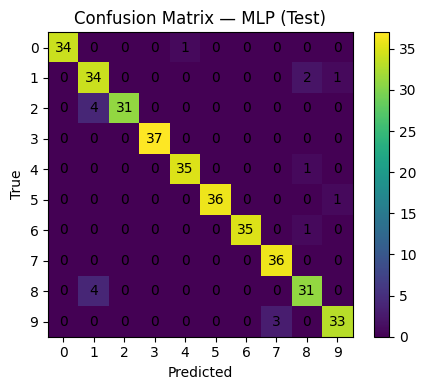

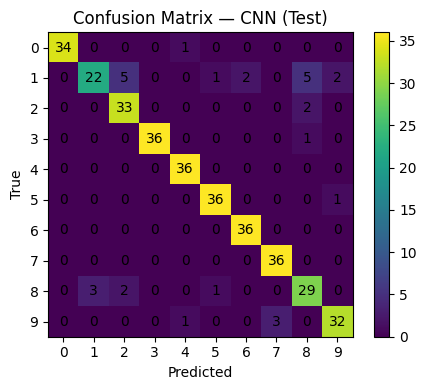

In [17]:
# Confusion matrices
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    # annotate
    for i in range(10):
        for j in range(10):
            plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.tight_layout()
    plt.show()

plot_confusion(y_true_mlp, y_pred_mlp, 'Confusion Matrix — MLP (Test)')
plot_confusion(y_true_cnn, y_pred_cnn, 'Confusion Matrix — CNN (Test)')

## 7. Discussion & Error Analysis
- **Logistic Regression (baseline)** achieved the top scores in this run — **Val: 0.9582**, **Test: 0.9556**.
- **MLP** met the success criterion — **Val: 0.9526**, **Test: 0.9500** (≥ 0.95 on test).
- **Small CNN** underperformed relative to both — **Val: 0.9304**, **Test: 0.9167**.

**Why this ordering?** With tiny 8×8 inputs, the problem is fairly separable; a strong linear baseline can excel. Our compact CNN likely over‑pooled on already small feature maps (8→4→2), losing spatial detail; it may also benefit from slightly more capacity or epochs.

**Error analysis.** Misclassifications concentrate among visually similar digits (e.g., `1`’s variability; `3↔5`, `4↔9`). See confusion matrices and the misclassified thumbnails for patterns to target with architecture/regularization tweaks.

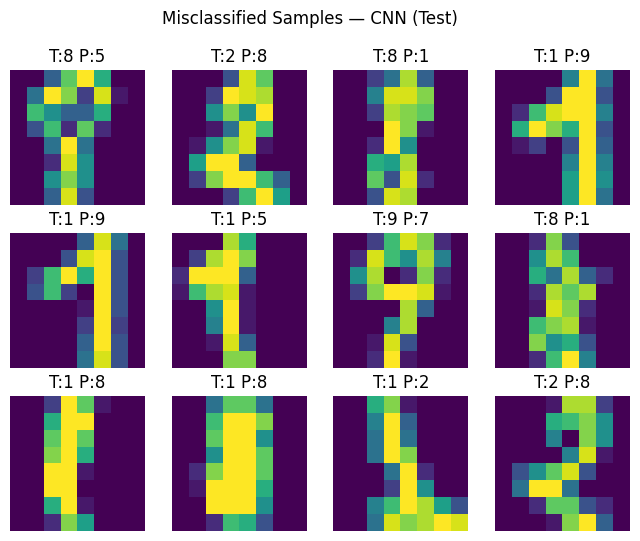

In [18]:
# Show some misclassified examples for CNN
mis_idx = np.where(y_true_cnn != y_pred_cnn)[0]
n_show = min(12, len(mis_idx))
if n_show > 0:
    sel = np.random.choice(mis_idx, n_show, replace=False)
    fig, axes = plt.subplots(3, 4, figsize=(8,6))
    for ax, i in zip(axes.flat, sel):
        ax.imshow(X_test[i])
        ax.set_title(f'T:{y_true_cnn[i]} P:{y_pred_cnn[i]}')
        ax.axis('off')
    plt.suptitle('Misclassified Samples — CNN (Test)')
    plt.show()
else:
    print('No misclassifications found (CNN).')

## 8. Conclusion & Next Steps
- **Conclusion.** The project’s ≥0.95 test‑accuracy target was **met** by the **MLP (0.9500)** and exceeded by the **LogReg baseline (0.9556)**, while the **CNN (0.9167)** fell short in this configuration.

- **Next steps.**
  1. **CNN architecture:** reduce/avoid early pooling on 8×8; try Conv→Conv→Flatten (no pool) or one pool only; add BatchNorm; widen channels (e.g., 16→32→64).
  2. **Training/HPO:** longer training (30–40 epochs), LR scheduling (cosine/step), small weight decay and dropout sweeps.
  3. **Augmentation:** mild shifts/rotations or elastic transforms; keep them subtle to avoid destroying 8×8 signal.
  4. **Evaluation:** 5‑fold CV to stabilize metrics on this small dataset.

## 9. Reproducibility & How to Run
- Install: `pip install numpy pandas matplotlib scikit-learn torch torchvision`
- Run top‑to‑bottom; CPU is sufficient.
- Random seeds fixed at 42; note that CuDNN may introduce nondeterminism if run on GPU.

## 10. References
- scikit‑learn Digits dataset: `sklearn.datasets.load_digits`
- Goodfellow et al., *Deep Learning*, MIT Press.
- PyTorch documentation (https://pytorch.org).